In [2]:
import cv2
import numpy as np
import time
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [43]:
def save(model, i=None, name=None):
    i = i or 0
    name = name or type(model).__name__ + str(i)
    torch.save(model.state_dict(), 'dat/' + name + '.pth')

def load(model, i=None, name=None):
    i = i or 0
    name = name or type(model).__name__ + str(i)
    model.load_state_dict(torch.load('dat/' + name + '.pth'))

In [5]:
class FrameDataset(Dataset):
    def __init__(self, img_dir, n, transform=None, target_transform=None):
        self.img_dir = img_dir.rstrip('/').rstrip('\\')
        self.n = n
        with open(self.img_dir + '/control.dat', "r") as f:
            self.frame_map = np.array(f.read().split(' '), dtype='int32')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return min(self.n-2, len(self.frame_map))

    def __getitem__(self, idx):
        img_path = self.img_dir + '/frame%d.jpg'
        idx = self.frame_map[idx]
        im1 = cv2.imread(img_path % idx)
        label = cv2.imread(img_path % (idx+1))
        im2 = cv2.imread(img_path % (idx+2))
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        if self.target_transform:
            label = self.target_transform(label)
        image = [im1,im2]
        return torch.Tensor(np.array(image)), torch.Tensor(np.array([label]))

In [38]:
#inspired by https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding='same')
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding='same')
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

class Encoder(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.bl0 = Block(channels,16)
        self.bl1 = Block(16,32)
        self.bl2 = Block(32,64)
        self.bl3 = Block(64,128)
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        links = []
        x = self.bl0(x)
        links.append(x)
        x = self.pool(x)
        x = self.bl1(x)
        links.append(x)
        x = self.pool(x)
        x = self.bl2(x)
        links.append(x)
        x = self.pool(x)
        x = self.bl3(x)
        links.append(x)
        return links

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bl0 = Block(128,64)
        self.bl1 = Block(64,32)
        self.bl2 = Block(32,16)
        self.upsc0 = nn.ConvTranspose2d(128,64,3,2,1,1)
        self.upsc1 = nn.ConvTranspose2d(64,32,3,2,1,1)
        self.upsc2 = nn.ConvTranspose2d(32,16,3,2,1,1)
        self.flatch = nn.Conv2d(16,1,1)
    
    def forward(self, x, links):
        x = self.upsc0(x)
        x = self.bl0(torch.cat((x, links[0]), dim = 1))
        x = self.upsc1(x)
        x = self.bl1(torch.cat((x, links[1]), dim = 1))
        x = self.upsc2(x)
        x = self.bl2(torch.cat((x, links[2]), dim = 1))
        return self.flatch(x)
    
        
        x = self.upscl[i](x)
        x = self.main[i](torch.cat((x, links), dim = 1))
        return self.flatch(x)

class UNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.enc = Encoder(input_shape[2])
        self.dec = Decoder()
    
    def forward(self, x):
        links = self.enc(x)[::-1]
        x = self.dec(links[0], links[1:])
        return x

class UNetB(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.enc = Encoder(input_shape[2]//2)
        self.dec = Decoder()
    
    def forward(self, x):
        linksA = self.enc(x[:,0:1,:,:])[::-1]
        linksB = self.enc(x[:,1:2,:,:])[::-1]
        x = self.dec(linksA[0]+linksB[0], linksA[1:]+linksB[1:])
        return x

In [7]:
enc = Encoder(2)
x = torch.randn(4,2,360,360)
links = enc(x)
for l in links:
    print(l.shape)
dec = Decoder()
x = links[-1]
dec(x,links[::-1][1:]).shape

torch.Size([4, 16, 360, 360])
torch.Size([4, 32, 180, 180])
torch.Size([4, 64, 90, 90])
torch.Size([4, 128, 45, 45])


torch.Size([4, 1, 360, 360])

In [21]:
model = UNetB((360,360,2)).to(device)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, betas=(0.5, 0.999))

In [10]:
def puppy(im):
    return im[:,:,0]/128 - 1

training_data = FrameDataset('dat/part0/',2000, puppy, puppy)
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
training_loss = []

In [ ]:
load(model)

In [28]:
model.train()
t = 0
for epoch in range(5):

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, loss.item()))
            training_loss.append(loss.item())

    if time.time() > t + 1000:
        save(model)
        t = time.time()
        print('Model checkpoint')

save(model)
print('Finished Training')

[1,     1] loss: 0.0257
[1,    11] loss: 0.0416
[1,    21] loss: 0.0287
[1,    31] loss: 0.0320
[1,    41] loss: 0.0196
[1,    51] loss: 0.0271
[1,    61] loss: 0.0396
[1,    71] loss: 0.0295
[1,    81] loss: 0.0275
[1,    91] loss: 0.0263
[1,   101] loss: 0.0214
[1,   111] loss: 0.0269
[1,   121] loss: 0.0331
Model checkpoint
[2,     1] loss: 0.0228
[2,    11] loss: 0.0282
[2,    21] loss: 0.0294
[2,    31] loss: 0.0302
[2,    41] loss: 0.0243
[2,    51] loss: 0.0428
[2,    61] loss: 0.0189
[2,    71] loss: 0.0284
[2,    81] loss: 0.0253
[2,    91] loss: 0.0233
[2,   101] loss: 0.0265
[2,   111] loss: 0.0330
[2,   121] loss: 0.0140
[3,     1] loss: 0.0377
[3,    11] loss: 0.0307
[3,    21] loss: 0.0318
[3,    31] loss: 0.0269
[3,    41] loss: 0.0158
[3,    51] loss: 0.0326
[3,    61] loss: 0.0367
[3,    71] loss: 0.0218
[3,    81] loss: 0.0269
[3,    91] loss: 0.0256
[3,   101] loss: 0.0185
[3,   111] loss: 0.0333
[3,   121] loss: 0.0319
[4,     1] loss: 0.0375
[4,    11] loss: 0.0350

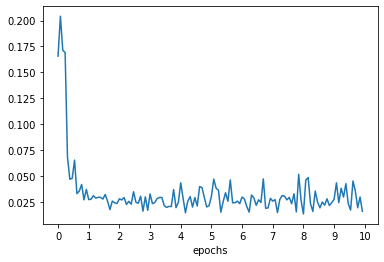

In [52]:
plt.plot(training_lossA)
plt.xticks(np.arange(0,131,13),np.arange(11))
plt.xlabel('epochs')
plt.show()

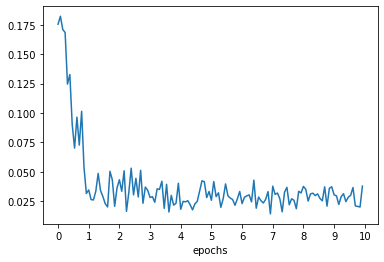

In [51]:
plt.plot(training_lossB)
plt.xticks(np.arange(0,131,13),np.arange(11))
plt.xlabel('epochs')
plt.show()

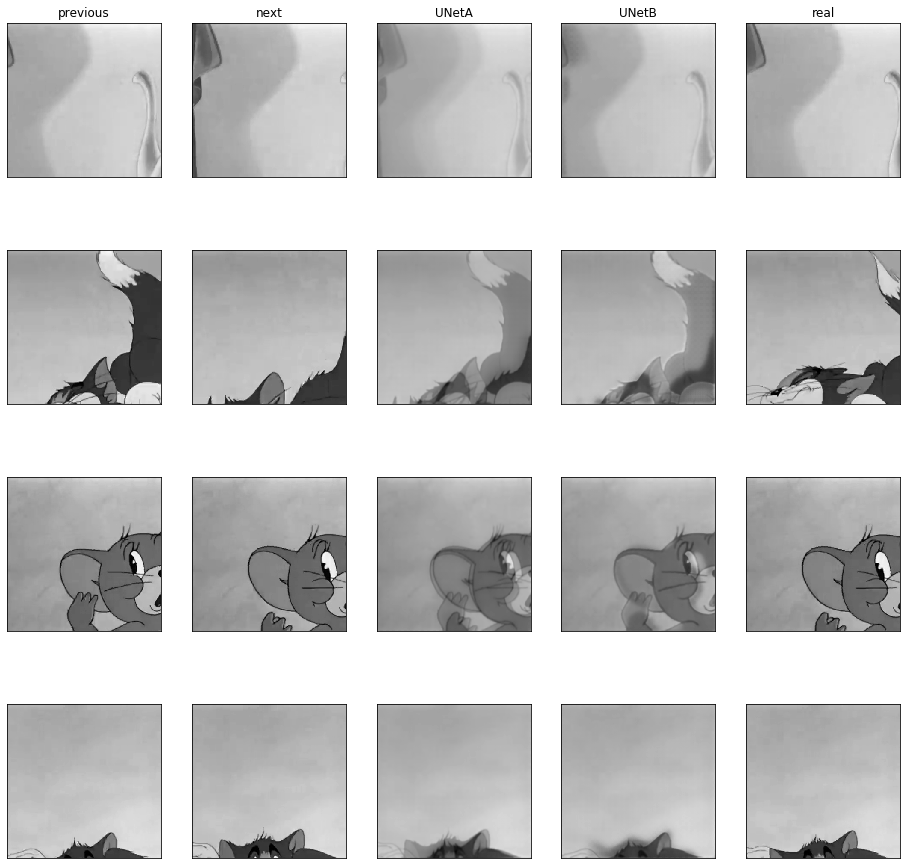

In [60]:
model = UNet((360,360,2))
load(model)
model.to(device)

figure, axes = plt.subplots(4,5, figsize=(16,16))
for i in range(4):
    for j in range(5):
        axes[0][j].set_title(['previous','next','UNetA','UNetB','real'][j])
        axes[i][j].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

with torch.no_grad():
    n=4
    ins = inputs.cpu().detach()
    outsA = model(inputs).cpu().detach()
    outsB = outputs.cpu().detach()
    mids = labels.cpu().detach()
    for i in range(4):
        axes[i][0].imshow(ins[n*i][0],cmap='gray', vmin=-1, vmax=1)
        axes[i][1].imshow(ins[n*i][1],cmap='gray', vmin=-1, vmax=1)
        axes[i][2].imshow(outsA[n*i][0],cmap='gray', vmin=-1, vmax=1)
        axes[i][3].imshow(outsB[n*i][0],cmap='gray', vmin=-1, vmax=1)
        axes[i][4].imshow(mids[n*i][0],cmap='gray', vmin=-1, vmax=1)

plt.show()